In [1]:
import numpy as np
import random

#     # some_file.py
# import sys
#     # caution: path[0] is reserved for script path (or '' in REPL)
# sys.path.insert(1, '/home/jbara/Documents/Warwick/PhD/Collaborators/Fernando/Spatial pollution/Code')
# import pollution
# from pollution import Agent

import matplotlib.pyplot as plt
import matplotlib
from tqdm import trange
import tqdm
import os
import imageio
import math
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import networkx as nx
import os
import math
import matplotlib.ticker as mtick
import ipywidgets as widgets
from scipy.optimize import minimize_scalar, minimize
from matplotlib.lines import Line2D

font = {        'size'   : 20}
mpl.rc('font', **font)
%matplotlib notebook

In [2]:
def P(x,R=10,x0=0):
    if type(x)!=np.ndarray:
        if np.abs(x-x0)<=1:
            return 1
        elif np.abs(x-x0)<=R:
            return 1/(x-x0)**2
        else:
            return 0
    else:
        p = np.zeros_like(x)
        p[np.abs(x-x0)<=1] = 1
        p[(np.abs(x-x0)>1)&(np.abs(x-x0)<=R)]=1/(x[(np.abs(x-x0)>1)&(np.abs(x-x0)<=R)]-x0)**2
        return p
        

def m_cost(x,mu=1,x0=1):
    if type(x)!=np.ndarray:
        if x<x0:
            return mu*(x0-x)
        else:
            return mu*(x0-1)
    else:
        p=np.zeros_like(x)
        p[x<x0]=mu*(x0-x[x<x0])
        p[x>=x0]=mu*(x[x>=x0]-x0)
        return p

def clean(x,phi=5,x0=1):
    if type(x)!=np.ndarray:
        if (x>=x0-1) & (x<=x0+1):
            return -phi
        else:
            return 0
    else:
        p=np.zeros_like(x)
        p[(x>=x0-1) & (x<=x0+1)] = -phi
        return p
    
def total_cost(x,mu=1,phi=5,R=10,x0=1):
    return P(x,R=R)+m_cost(x,mu=mu,x0=1)+clean(x,phi=phi,x0=1)

def min_under_mu(mu,x=np.linspace(-20,20,1000)):
#     x=np.linspace(-20,20,10000)
    y= np.array([total_cost(x[i],mu=mu) for i in range(len(x))])
    return x[np.argmin(y)]

In [128]:
# Drawing the stationary points of total_cost as a phase diagram against mu
    # 1D1C
def plot_stat_points_1d1c(mu,phi=5,R=10,ax=None,
                          gminc='forestgreen',glw=3,gminlab='G-Min',
                          minc='royalblue',minls='-',minlab='L-Min',
                          maxc='crimson',maxls=':',maxlab='Max',
                          disc='royalblue',disls='--',dislab='D-Min',
                          legend_loc='lower right',scale='lin',mobile='c',
                          legend=True):
    # Stationary points for the one-defector-one-cooperator case 
        # with D at the origin and C at x=1
        # mobile controls who will move
    def add_arrow(line, position=None, direction='right', size=15, color=None):
        """
        add an arrow to a line.

        line:       Line2D object
        position:   x-position of the arrow. If None, mean of xdata is taken
        direction:  'left' or 'right'
        size:       size of the arrow in fontsize points
        color:      if None, line color is taken.
        """
        if color is None:
            color = line.get_color()

        xdata = line.get_xdata()
        ydata = line.get_ydata()

        if position is None:
            position = xdata.mean()
        # find closest index
        start_ind = np.argmin(np.absolute(xdata - position))
        if direction == 'right':
            end_ind = start_ind + 2
        else:
            end_ind = start_ind - 2

        line.axes.annotate('',
            xytext=(xdata[start_ind], ydata[start_ind]),
            xy=(xdata[end_ind], ydata[end_ind]),
            arrowprops=dict(arrowstyle="simple", color=color),
            size=size
        )
    
    if ax == None:
        fig,ax=plt.subplots(figsize=(10,8))
#     if min(mu)>0:
#     # Move left y-axis and bottim x-axis to centre, passing through (0,0)
#         ax.spines['left'].set_position(('data',0))

#     # Eliminate upper and right axes
#     ax.spines['right'].set_color('none')
#     ax.spines['top'].set_color('none')
#     ax.spines['bottom'].set_position(('data',0))
    ax.set_xlabel("Migration, $\mu$")#,loc='right',labelpad=-50)
    ax.set_ylabel("Position, $x_*$")#,loc='top',labelpad=-10)
    ax.set_xlim([min(mu),max(mu)])
    ax.set_ylim([-R-1/2,R+1/2])
        
    mu_a = mu[mu<0]
    mu_b = mu[(mu>=0)&(mu<2/(R**3))]
    mu_c = mu[(mu>=2/(R**3))&(mu<1/4)]
    mu_d = mu[(mu>=1/4)&(mu<2)]
    mu_e = mu[(mu>=2)]
    
    # Maxima same for both C&D
    ax.plot(mu[mu<=0],[1]*len(mu[mu<=0]),c=maxc,ls=maxls)
    ax.plot(mu[(mu>=0)&(mu<=2)],[-1]*len(mu[(mu>=0)&(mu<=2)]),c=maxc,ls=maxls)
    
    ax.plot(mu_b,[R]*len(mu_b),c=minc,ls=minls)
    ax.plot(mu_b,[-R]*len(mu_b),c=minc,ls=minls)
    ax.plot(mu[mu>=2/R**3],[R]*len(mu[mu>=2/R**3]),c=disc,ls=disls,
            label=dislab)
    ax.plot(mu[mu>=2/R**3],[-R]*len(mu[mu>=2/R**3]),c=disc,ls=disls)
    
    ax.plot(mu_c,np.cbrt(2/mu_c),c=minc,ls=minls,label=minlab)
    ax.plot(mu_c,-np.cbrt(2/mu_c),c=minc,ls=minls)
    ax.plot(mu_d,-np.cbrt(2/mu_d),c=minc,ls=minls)
    
    ax.plot(mu_d,np.cbrt(2/mu_d),c=minc,ls=minls)
    
    if mobile=='c':
        ax.plot(mu,[0]*len(mu),c=disc,ls=disls)
        g1=ax.plot(mu[mu<=0.25],[2]*len(mu[mu<=0.25]),c=gminc,lw=glw)[0]
        g2=ax.plot(mu_b,[2]*len(mu_b),c=gminc,lw=glw)[0]
        g3=ax.plot(mu_d,np.cbrt(2/mu_d),c=gminc,lw=glw)[0]
        g4=ax.plot(mu_e,[1]*len(mu_e),c=gminc,lw=glw)[0]
        add_arrow(g1,size=20)
        add_arrow(g3,size=20)    
        add_arrow(g4,size=20)
    elif mobile=='d':
        mu_disc=2/3**(3/2)
        ax.plot(mu,[0]*len(mu),c=minc,ls=minls)
        g1=ax.plot(mu[mu<=0.25],[2]*len(mu[mu<=0.25]),c=gminc,lw=glw)[0]
        g2=ax.plot(mu[(mu>=0.25)&(mu<=mu_disc)],
                   np.cbrt(2/mu[(mu>=0.25)&(mu<=mu_disc)]),
                   lw=glw,c=gminc)[0]
        g3=ax.plot(mu[(mu>=mu_disc)],
                   [0]*len(mu[(mu>=mu_disc)]),
                   lw=glw,c=gminc)[0]
        add_arrow(g1,size=20)
        add_arrow(g2,size=20)
        add_arrow(g3,size=20)
        ax.scatter([mu_disc]*2,
                   [0,np.cbrt(2/mu_disc)],
                   c=gminc,marker='o',s=10)
    
    if legend:
        gline = Line2D([0], [0], color=gminc, lw=glw, label=gminlab,marker='>',ms=10)
        mline = Line2D([0], [0], color=minc, ls=minls, label=minlab)
        dline = Line2D([0], [0], color=disc, ls=disls, label=dislab)
        maxline = Line2D([0], [0], color=maxc, ls=maxls, label=maxlab)
        ax.legend(handles=[maxline,dline,mline,gline],loc=legend_loc)
    else:
        if mobile=='c':
            title='Mobile Cooperator' 
        elif mobile=='d':
            title='Mobile Defector'
        else: 
            title='Mobile ?'
        ax.text(0.95,0.91, title, fontsize = 15, 
                bbox = dict(facecolor = 'white',
                            edgecolor='black',
                            boxstyle='round,pad=0.5'),
                ha='right',va='top',
                transform = ax.transAxes)
    if scale=='log':
        ax.set_xscale('log')
        ax.set_xlim([min(mu[mu>0]),max(mu)])
        ax.set_xticks([0.01,2/R**3,0.1,0.25,1,2])
        ax.set_xticklabels([0.01,r'$2R^{-3}$',0.1,0.25,1,2])

<IPython.core.display.Javascript object>


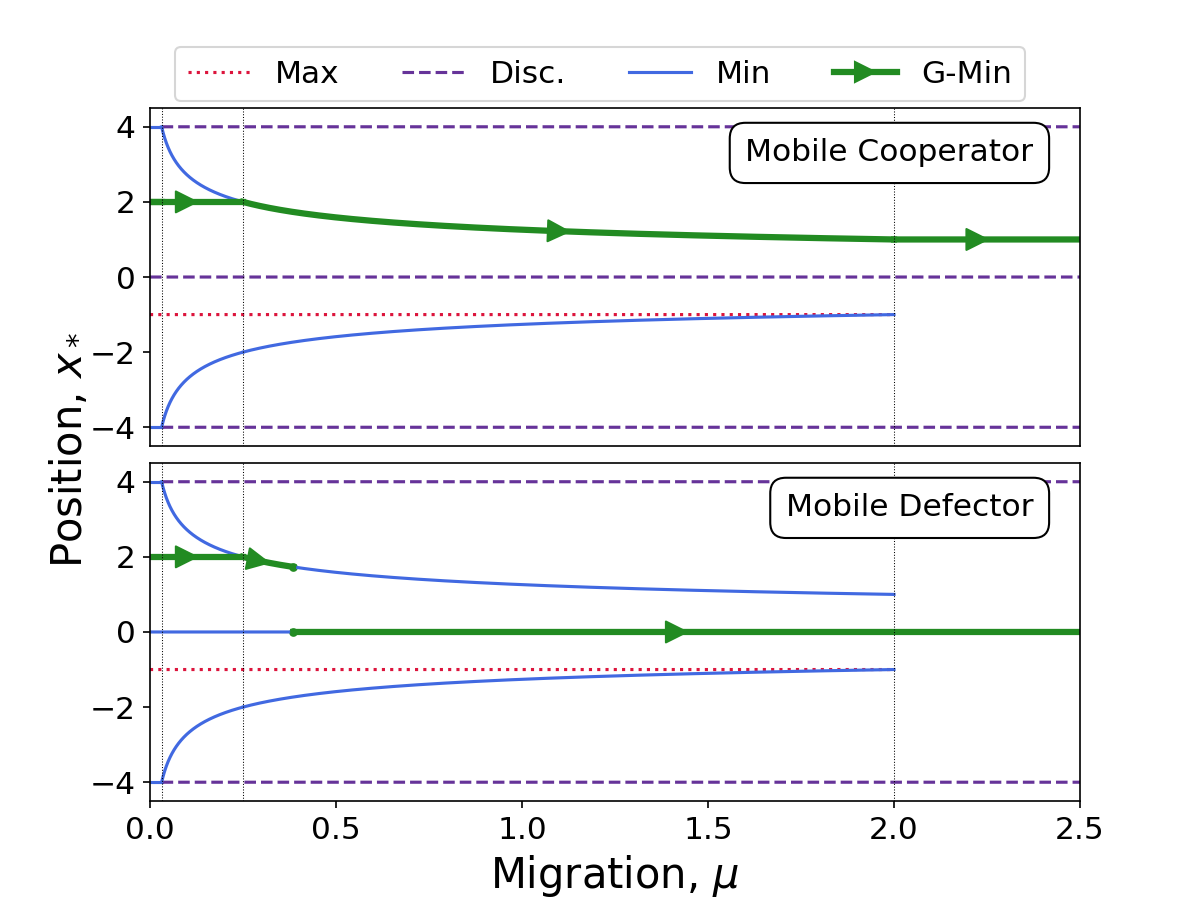

In [130]:
fig,axs=plt.subplots(figsize=(8,6),nrows=2,sharex=True)
fig.subplots_adjust(hspace=0.05)
mu = np.linspace(0,2.5,10000)
R=4
gminc,minc,disc,maxc=('forestgreen','royalblue','rebeccapurple','crimson')
dislab,minlab,maxlab,gminlab=('Disc.','Min','Max','G-Min')
glw=3
minls,maxls,disls=('-',':','--')

plot_stat_points_1d1c(mu,ax=axs[0],R=R,
                      gminc=gminc,minc=minc,maxc=maxc,disc=disc,
                      dislab=dislab,minlab=minlab,
                      maxlab=maxlab,gminlab=gminlab,
                      scale='lin',
                      mobile='c',legend=False)
plot_stat_points_1d1c(mu,ax=axs[1],R=R,
                      gminc=gminc,minc=minc,maxc=maxc,disc=disc,
                      dislab=dislab,minlab=minlab,
                      maxlab=maxlab,gminlab=gminlab,
                      scale='lin',
                      mobile='d',legend=False)

axs[0].axes.get_xaxis().set_visible(False)
gline = Line2D([0], [0], color=gminc, lw=glw, label=gminlab,marker='>',ms=10)
mline = Line2D([0], [0], color=minc, ls=minls, label=minlab)
dline = Line2D([0], [0], color=disc, ls=disls, label=dislab)
maxline = Line2D([0], [0], color=maxc, ls=maxls, label=maxlab)
fig.legend(handles=[maxline,dline,mline,gline],
           bbox_to_anchor=(0.5,0.965),loc='upper center',ncol=4,fontsize=15)
for ax in axs:
    ax.plot([2,2],[-4.5,4.5],'k:',lw=0.5)
    ax.plot([0.25,0.25],[-4.5,4.5],'k:',lw=0.5)
    ax.plot([2/(R**3)]*2,[-R-1,R+1],'k:',lw=0.5)
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='major', labelsize=15)
fig.text(0.04, 0.5, 'Position, $x_*$', va='center', rotation='vertical')

# ax.annotate(r"$2R^{-3}$",[2/(R**3),0],fontsize=15,rotation=-90,va='center')
# ax.annotate(r"$1/4$",[1/4,0],fontsize=15,rotation=270,va='bottom')

fig.savefig('Extension/Migratory notable points 1d1c.png',bbox_inches='tight')

In [61]:
print(labels)

['Disc.', 'Min']


<IPython.core.display.Javascript object>


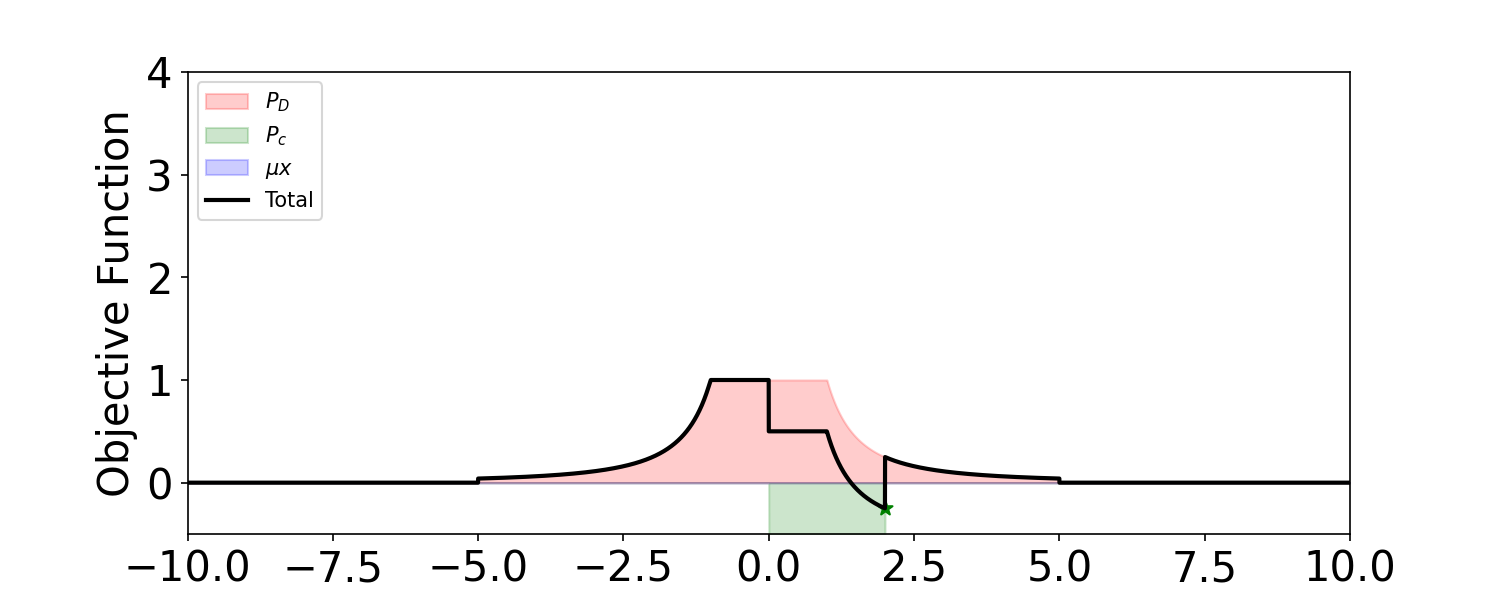

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-0.5, step=0.05), Dropdown(descrip…

In [5]:
fig,ax=plt.subplots(figsize=(10,4))
x0=1
x=np.linspace(-10,10,10000)

@widgets.interact(mu=(-0.5,3,0.05),R=[1,2,5,10],phi=[0.5,1,5])
def update(mu=0,R=5,phi=0.5):
    ax.clear()
    ax.fill_between(x,[0]*len(x),P(x,R=R),color='r',label='$P_D$',alpha=0.2,lw=1)
    ax.fill_between(x,clean(x,phi=phi,x0=x0),[0]*len(x),color='g',label='$P_c$',alpha=0.2,lw=1)
    ax.fill_between(x,[0]*len(x),m_cost(x,mu=mu,x0=x0),label='$\mu x$',color='b',lw=1,alpha=0.2)
    ax.plot(x,total_cost(x,mu=mu,x0=x0,R=R,phi=phi),label='Total',c='k',lw=2)
    ax.set_xlim([min(x),max(x)])
    ax.set_ylim([-phi,4])
    ax.scatter([x[np.argmin(total_cost(x,mu=mu,x0=x0,R=R,phi=phi))]],
            [np.min(total_cost(x,mu=mu,x0=x0,R=R,phi=phi))],
               marker='*',s=50,c='g')

    ax.legend(loc='upper left',fontsize=10)
    ax.set_xlabel("$x$")
    ax.set_ylabel("Objective Function")
    plt.show()

# Two Defectors

<IPython.core.display.Javascript object>


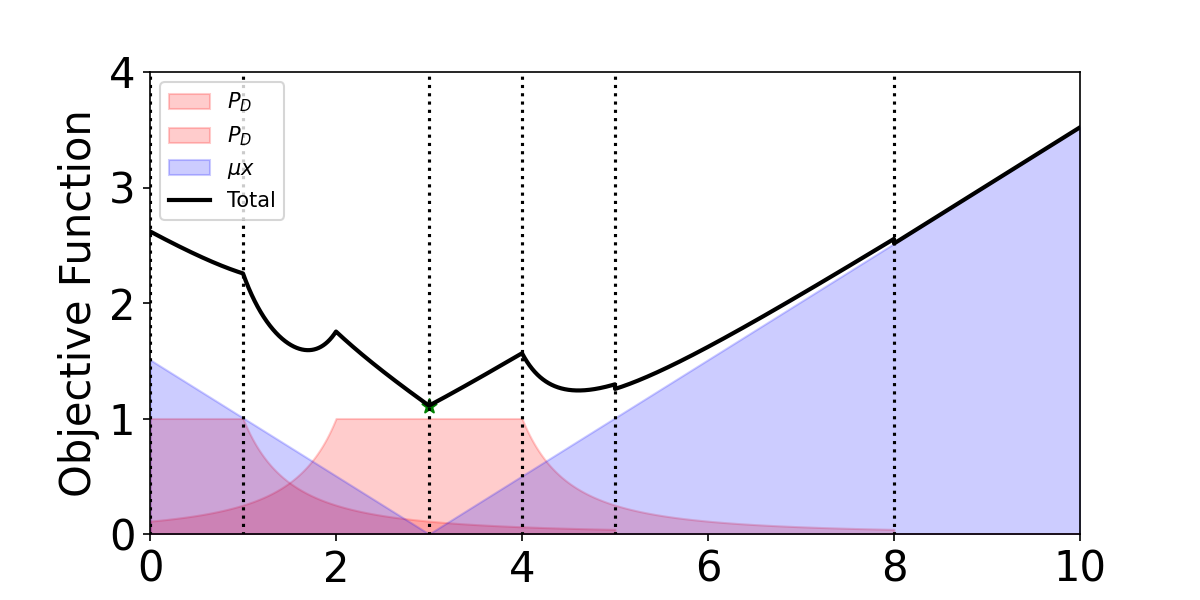

interactive(children=(FloatSlider(value=0.0, description='mu', max=2.5, min=-0.1, step=0.001), Dropdown(descri…

In [9]:
fig,ax=plt.subplots(figsize=(8,4))
# x0=1
x=np.linspace(0,10,10000)

@widgets.interact(mu=(-0.1,2.5,0.001),x0=(1,3,0.1),R=[1,2,5,10])
def update(mu=0,R=5,x0=1):
    ax.clear()
    ax.fill_between(x,[0]*len(x),P(x,R=R),color='r',label='$P_D$',alpha=0.2,lw=1)
    ax.fill_between(x,[0]*len(x),P(x,R=R,x0=x0),color='r',label='$P_D$',alpha=0.2,lw=1)
#     ax.fill_between(x,clean(x,phi=phi,x0=x0),[0]*len(x),color='g',label='$P_c$',alpha=0.2,lw=1)
    ax.fill_between(x,[0]*len(x),m_cost(x,mu=mu,x0=x0),label='$\mu x$',color='b',lw=1,alpha=0.2)
    ax.plot(x,
            P(x,R=R)+P(x,R=R,x0=x0)+m_cost(x,mu=mu,x0=x0),
            label='Total',c='k',lw=2)
    ax.set_xlim([min(x),max(x)])
    ax.set_ylim([0,4])
    
    ax.plot([-R]*2,[-1,4],'k:')
    ax.plot([-R+x0]*2,[-1,4],'k:')
    ax.plot([R+x0]*2,[-1,4],'k:')
    ax.plot([R]*2,[-1,4],'k:')
    ax.plot([-1]*2,[-1,4],'k:')
    ax.plot([0]*2,[-1,4],'k:')
    ax.plot([1]*2,[-1,4],'k:')
    ax.plot([x0]*2,[-1,4],'k:')
    ax.plot([x0+1]*2,[-1,4],'k:')
#     ax.plot([3]*2,[-1,4],'k:')
    
    ax.scatter([x[np.argmin(P(x,R=R)+P(x,R=R,x0=x0)+m_cost(x,mu=mu,x0=x0))]],
            [np.min(P(x,R=R)+P(x,R=R,x0=x0)+m_cost(x,mu=mu,x0=x0))],marker='*',s=50,c='g')

    ax.legend(loc='upper left',fontsize=10)
    ax.set_xlabel("$x$")
    ax.set_ylabel("Objective Function")
    plt.show()

In [10]:
def add_arrow(line, position=None, direction='right', size=15, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = min(start_ind + 1,len(xdata))
    else:
        end_ind = min(start_ind - 1,len(xdata))

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="simple", color=color),
        size=size
    )

def f_2d(x,par):
    mu,x1,R = par
    res = (np.abs(x)<1)*1 + (np.abs(x-x1)<1)*1 + np.abs(x-x1)*mu
    if (np.abs(x)>=1)&(np.abs(x)<R):
        res += 1/x**2
    if (np.abs(x-x1)>=1)&(np.abs(x-x1)<R):
        res += 1/(x-x1)**2
#     res[(np.abs(x)>=1)&(np.abs(x)<=R)] += 1/(x[(np.abs(x)>=1)&(np.abs(x)<=R)])**2
#     res[((np.abs(x-x1)>=1)&(np.abs(x-x1)<=R))] += 1/(x[((np.abs(x-x1)>=1)&(np.abs(x-x1)<=R))]-x1)**2
    return res
    
# Drawing the stationary points of total_cost as a phase diagram against mu
    # 2D

def plot_stat_points_2dx1(mu,phi=5,R=10,x1=1,ax=None,
                          gminc='forestgreen',glw=3,gminlab='G-Min',gls='-',
                          minc='royalblue',minls='-',minlab='L-Min',
                          maxc='crimson',maxls=':',maxlab='Max',
                          disc='rebeccapurple',disls='--',dislab='D-Min',
                          pc='royalblue',pls='--',plab='P-Min',
                          legend_loc='lower right',scale='lin',skip=2,disc_tol=0.5):
    
    if ax == None:
        fig,ax=plt.subplots(figsize=(10,8))
    gline = Line2D([0], [0], color=gminc, lw=glw, label=gminlab,marker='>',ms=10)
    mline = Line2D([0], [0], color=minc, ls=minls, label=minlab)
    pline = Line2D([0], [0], color=pc, ls=pls, label=plab)
    dline = Line2D([0], [0], color=disc, ls=disls, label=dislab)
    maxline = Line2D([0], [0], color=maxc, ls=maxls, label=maxlab)
    ax.legend(handles=[maxline,pline,dline,mline,gline],loc=legend_loc)
    ax.set_xlabel("Migration, $\mu$")#,loc='right',labelpad=-50)
    ax.set_ylabel("Position, $x_*$")#,loc='top',labelpad=-10)
    ax.set_xlim([min(mu),max(mu)])
    ax.set_ylim([-R-1/2,R+x1+1/2])
    
    if scale=='log':
        ax.set_xscale('log')
        ax.set_xlim([min(mu[mu>0]),max(mu)])
    
    if x1<1:
        print("Unaccounted for")
        return None
    
    if x1==R:
        masks = [mu<2/R**3, mu>0, mu>0,
                 mu<2/(1+x1)**3, mu<2/x1**3, mu<2, mu<2+2/(1+x1)**3]
    else:
        masks = [mu<2/R**3, mu<2/(R-x1)**3, mu<2*(1/R**3+1/(R-x1)**3),
                 mu<2/(1+x1)**3, mu<2/x1**3, mu<2, mu<2+2/(1+x1)**3]
    if x1>1:
        masks+=[mu<2/(x1-1)**3,mu<2-2/(x1-1)**3]
    else:
        masks+=[mu<0,mu<0]
    
    # a -> b; x* = -R
    ax.plot(mu[masks[0]],[-R]*len(mu[masks[0]]),
            ls=pls,c=pc)
    ax.plot(mu[~masks[0]],[-R]*len(mu[~masks[0]]),
            ls=disls,c=disc)
    
    # i->j; x* = x1+R
    ax.plot(mu[masks[0]],[x1+R]*len(mu[masks[0]]),
            ls=pls,c=pc) 
    ax.plot(mu[~masks[0]],[x1+R]*len(mu[~masks[0]]),
            ls=disls,c=disc)
    
    if 1<=x1<=2:
        # b; x* = -cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[1]],-np.cbrt(2/mu[~masks[0]&masks[1]]),
                ls=minls,c=minc)
        
        # b -> c; x* = x1-R
        ax.plot(mu[~masks[1]&masks[2]],[x1-R]*len(mu[~masks[1]&masks[2]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[2]],[x1-R]*len(mu[~masks[2]]),
                ls=disls,c=disc)
        
        # c; awkward polynomial root
        x_minus = np.linspace(x1-R,-1,len(mu[~masks[2]&masks[6]]))
        ax.plot(-2*(1/x_minus**3+1/(x_minus-x1)**3),x_minus,
                c=minc,ls=minls) 
        
        # c->d; x* = -1
        ax.plot(mu[~masks[3]&masks[6]],[-1]*len(mu[~masks[3]&masks[6]]),
               ls=maxls,c=maxc)
        # d; x* = x1-cbrt(2/mu)
        ax.plot(mu[~masks[3]&masks[5]],x1-np.cbrt(2/mu[~masks[3]&masks[5]]),
                c=minc,ls=minls) 
        # d->e; x* = x1-1
        ax.plot(mu[masks[5]],[x1-1]*len(mu[masks[5]]),
                ls=maxls,c=maxc) 
        # f->g; x* = x1
        ax.plot(mu[~masks[4]],[x1]*len(mu[~masks[4]]),
                ls=minls,c=minc) 
        # g; x* = cbrt(2/mu)
        ax.plot(mu[~masks[3]&masks[4]],np.cbrt(2/mu[~masks[3]&masks[4]]),
                ls=minls,c=minc)
        # g->h; x*=x1+1
        ax.plot(mu[~masks[3]&masks[6]],[x1+1]*len(mu[~masks[3]&masks[6]]),
                   ls=maxls,c=maxc) 
        
        # h; awkward poly root
        x_plus = np.linspace(x1+1,R,len(mu[~masks[2]&masks[6]]))
        ax.plot(2*(1/x_plus**3+1/(x_plus-x1)**3),x_plus,
            c=minc,ls=minls) 
        
        # h->i; x* = R
        ax.plot(mu[~masks[1]&masks[2]],[R]*len(mu[~masks[1]&masks[2]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[2]],[R]*len(mu[~masks[2]]),
                ls=disls,c=disc)
        
        # i; x* = x1+cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[1]],x1+np.cbrt(2/mu[~masks[0]&masks[1]]),
                ls=minls,c=minc)  
        
    elif 2<x1<=R-1:          
        # b; x* = -cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[1]],-np.cbrt(2/mu[~masks[0]&masks[1]]),
                ls=minls,c=minc)
        
        # b -> c; x* = x1-R
        ax.plot(mu[~masks[1]&masks[2]],[x1-R]*len(mu[~masks[1]&masks[2]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[2]],[x1-R]*len(mu[~masks[2]]),
                ls=disls,c=disc)
        
        # c; awkward polynomial root
        x_minus = np.linspace(x1-R,-1,len(mu[~masks[2]&masks[6]]))
        ax.plot(-2*(1/x_minus**3+1/(x_minus-x1)**3),x_minus,
                c=minc,ls=minls) 
        
        # c->d; x* = -1
        ax.plot(mu[~masks[3]&masks[6]],[-1]*len(mu[~masks[3]&masks[6]]),
               ls=maxls,c=maxc)
        
        # d; x* = x1-cbrt(2/mu)
        ax.plot(mu[~masks[3]&masks[7]],x1-np.cbrt(2/mu[~masks[3]&masks[7]]),
                ls=minls,c=minc) 
        
        # d->e; x* = 1
        ax.plot(mu[masks[7]],[1]*len(mu[masks[7]]),
                ls=maxls,c=maxc) 
        
        # e; weird poly root
        xe = np.linspace(1,x1-1)
        ax.plot(-2/xe**3+2/(x1-xe)**3,xe,ls=minls,c=minc) 
        
        # e->f; x* = x1-1
        ax.plot(mu[masks[8]],[x1-1]*len(mu[masks[8]]),ls=maxls,c=maxc) 

        # f->g; x* = x1
        ax.plot(mu[~masks[4]],[x1]*len(mu[~masks[4]]),ls=minls,c=minc) 
        
        # g; x* = cbrt(2/mu)
        ax.plot(mu[~masks[3]&masks[4]],np.cbrt(2/mu[~masks[3]&masks[4]]),
                ls=minls,c=minc)
        # g->h; x* = x1+1
        ax.plot(mu[~masks[3]&masks[6]],[x1+1]*len(mu[~masks[3]&masks[6]]),
                   ls=maxls,c=maxc)
        
        # h; weird poly root
        xh = np.linspace(x1+1,R)
        ax.plot(2*(1/xh**3+1/(xh-x1)**3),xh,
                ls=minls,c=minc)
        
        # h->i; x* = R
        ax.plot(mu[~masks[1]&masks[2]],[R]*len(mu[~masks[1]&masks[2]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[2]],[R]*len(mu[~masks[2]]),
                ls=disls,c=disc)
        
        # i; x* = x1+cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[1]],x1+np.cbrt(2/mu[~masks[0]&masks[1]]),
                ls=minls,c=minc) 
    
    elif R-1<x1<=R:       
        # b; x* = -cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[5]],-np.cbrt(2/mu[~masks[0]&masks[5]]),
                ls=minls,c=minc)
        
        # b->c; x* = -1
        ax.plot(mu[masks[5]],[-1]*len(mu[masks[5]]),
               ls=maxls,c=maxc)
        
        # c->d; x*=x1-R
        ax.plot(mu[masks[0]],[x1-R]*len(mu[masks[0]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[0]],[x1-R]*len(mu[~masks[0]]),
                ls=disls,c=disc)
        
        # d; x*=x1-cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[7]],x1-np.cbrt(2/mu[~masks[0]&masks[7]]),
                c=minc,ls=minls)
        
        # d->e; x* = 1
        ax.plot(mu[masks[7]],[1]*len(mu[masks[7]]),
                ls=maxls,c=maxc) 
        
        # e; weird poly root
        xe = np.linspace(1,x1-1)
        ax.plot(-2/xe**3+2/(x1-xe)**3,xe,ls=minls,c=minc) 
        
        # e->f; x* = x1-1
        ax.plot(mu[masks[8]],[x1-1]*len(mu[masks[8]]),ls=maxls,c=maxc) 
        
        # f->g; x* = x1
        ax.plot(mu[~masks[4]],[x1]*len(mu[~masks[4]]),
                ls=minls,c=minc) 
        
        # g; x*=xbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[4]],np.cbrt(2/mu[~masks[0]&masks[4]]),
                ls=minls,c=minc)
        
        # g->h; x*=R
        ax.plot(mu[masks[0]],[R]*len(mu[masks[0]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[0]],[R]*len(mu[~masks[0]]),
                ls=disls,c=disc)
        
        # h->i; x*=x1+1
        ax.plot(mu[masks[5]],[x1+1]*len(mu[masks[5]]),
                ls=minls,c=minc)
        
        # i; x* = x1+cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[5]],x1+np.cbrt(2/mu[~masks[0]&masks[5]]),
                ls=minls,c=minc) 
        
    elif R<x1<R+1:
        # b; x* = -cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[5]],-np.cbrt(2/mu[~masks[0]&masks[5]]),
                ls=pls,c=pc)
        
        # b->c; x* = -1
        ax.plot(mu[masks[5]],[-1]*len(mu[masks[5]]),
               ls=maxls,c=maxc)
        
        # c->d; x*=x1-R
        ax.plot(mu[masks[0]],[x1-R]*len(mu[masks[0]]),
                ls=pls,c=pc)
        ax.plot(mu[~masks[0]],[x1-R]*len(mu[~masks[0]]),
                ls=disls,c=disc)
        
        # d; x*=x1-cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[7]],x1-np.cbrt(2/mu[~masks[0]&masks[7]]),
                c=minc,ls=minls)
        
        # d->e; x* = 1
        ax.plot(mu[masks[7]],[1]*len(mu[masks[7]]),
                ls=maxls,c=maxc) 
        
        # e; weird poly root
        xe = np.linspace(1,x1-1)
        ax.plot(-2/xe**3+2/(xe-x1)**3,xe,ls=minls,c=minc) 
        
        # e->f; x* = x1-1
        ax.plot(mu[masks[8]],[x1-1]*len(mu[masks[8]]),ls=maxls,c=maxc) 
        
        # g->h; x* = x1
        ax.plot(mu,[x1]*len(mu),
                ls=minls,c=minc) 
        
        # h->i; x*=x1+1
        ax.plot(mu[masks[5]],[x1+1]*len(mu[masks[5]]),
                ls=maxls,c=maxc)
        
        # i; x* = x1+cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[5]],x1+np.cbrt(2/mu[~masks[0]&masks[5]]),
                ls=minls,c=minc) 
        
    elif R+1<=x1<=2*R:
        # b; x* = -cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[5]],-np.cbrt(2/mu[~masks[0]&masks[5]]),
                ls=pls,c=pc)
        # b->c; x* = -1
        ax.plot(mu[masks[5]],[-1]*len(mu[masks[5]]),
               ls=maxls,c=maxc)
        
        # d->e; x* = x1-R
        ax.plot(mu,[x1-R]*len(mu),ls=disls,c=disc)
        
        # e; weird poly root
        xe = np.linspace(x1-R,R)
        ax.plot(-2/xe**3+2/(xe-x1)**3,xe,ls=minls,c=minc) 
        
        # e->f; x* = R
        ax.plot(mu[(mu<-2/R**3 + 2/(x1-R)**3)],
                [R]*len(mu[(mu<-2/R**3 + 2/(x1-R)**3)]),
                ls=disls,c=disc)
        ax.plot(mu[(mu>=-2/R**3 + 2/(x1-R)**3)&(mu<2/(x1-R)**3)],
                [R]*len(mu[(mu>=-2/R**3 + 2/(x1-R)**3)&(mu<2/(x1-R)**3)]),
                ls=pls,c=pc)
        
        # f; x* = x1-cbrt(2/mu)
        ax.plot(mu[(mu>=2/(x1-R)**3)&(mu<2)],x1-np.cbrt(2/mu[(mu>=2/(x1-R)**3)&(mu<2)]),
                ls=minls,c=minc)
        
        # f->g; x*=x1-1
        ax.plot(mu[mu<=2],[x1-1]*len(mu[mu<=2]),ls=maxls,c=maxc)
        
        # g->h; x* = x1
        ax.plot(mu,[x1]*len(mu),
                ls=minls,c=minc) 
        
        # h->i; x*=x1+1
        ax.plot(mu[masks[5]],[x1+1]*len(mu[masks[5]]),
                ls=maxls,c=maxc)
        
        # i; x* = x1+cbrt(2/mu)
        ax.plot(mu[~masks[0]&masks[5]],x1+np.cbrt(2/mu[~masks[0]&masks[5]]),
                ls=minls,c=minc) 
        
    x_gmin = np.array([minimize_scalar(f_2d,method='bounded',
                                       bounds=(-R-0.5,R+x1+0.5),
                                       args=[Mu,x1,R]).x for Mu in mu[::skip]])
    pos = np.where(np.abs(np.diff(x_gmin)) >= disc_tol)[0]+1
    x_gmin = np.insert(x_gmin,pos,np.nan)
    g0 = ax.plot(np.insert(mu[::skip],pos,np.nan),
                 x_gmin,c=gminc,ls=gls,lw=glw)[0]
    add_arrow(g0)

<IPython.core.display.Javascript object>


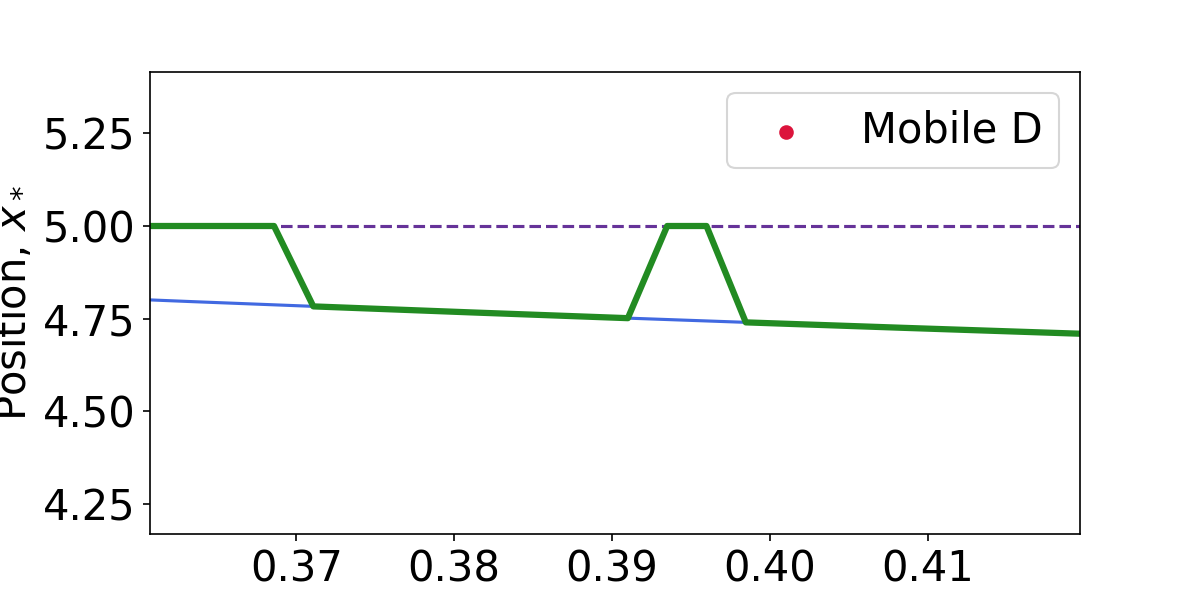

interactive(children=(FloatSlider(value=1.0, description='x1', max=6.0, min=1.0), Dropdown(description='R', in…

In [11]:
fig,ax=plt.subplots(figsize=(8,4))
R=5
mu = np.linspace(0.01,2.5,10000)
@widgets.interact(x1=(1,6,0.1),R=[2,3,4,5])
def update(x1=1,R=5):
    ax.clear()
    plot_stat_points_2dx1(mu,ax=fig.gca(),R=R,x1=x1,
                          legend_loc='center left',scale='',skip=10,disc_tol=2)
    ax.set_ylim([-R-1,R+7])
    ax.scatter(0,x1,c='crimson',label='Mobile D')
    ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


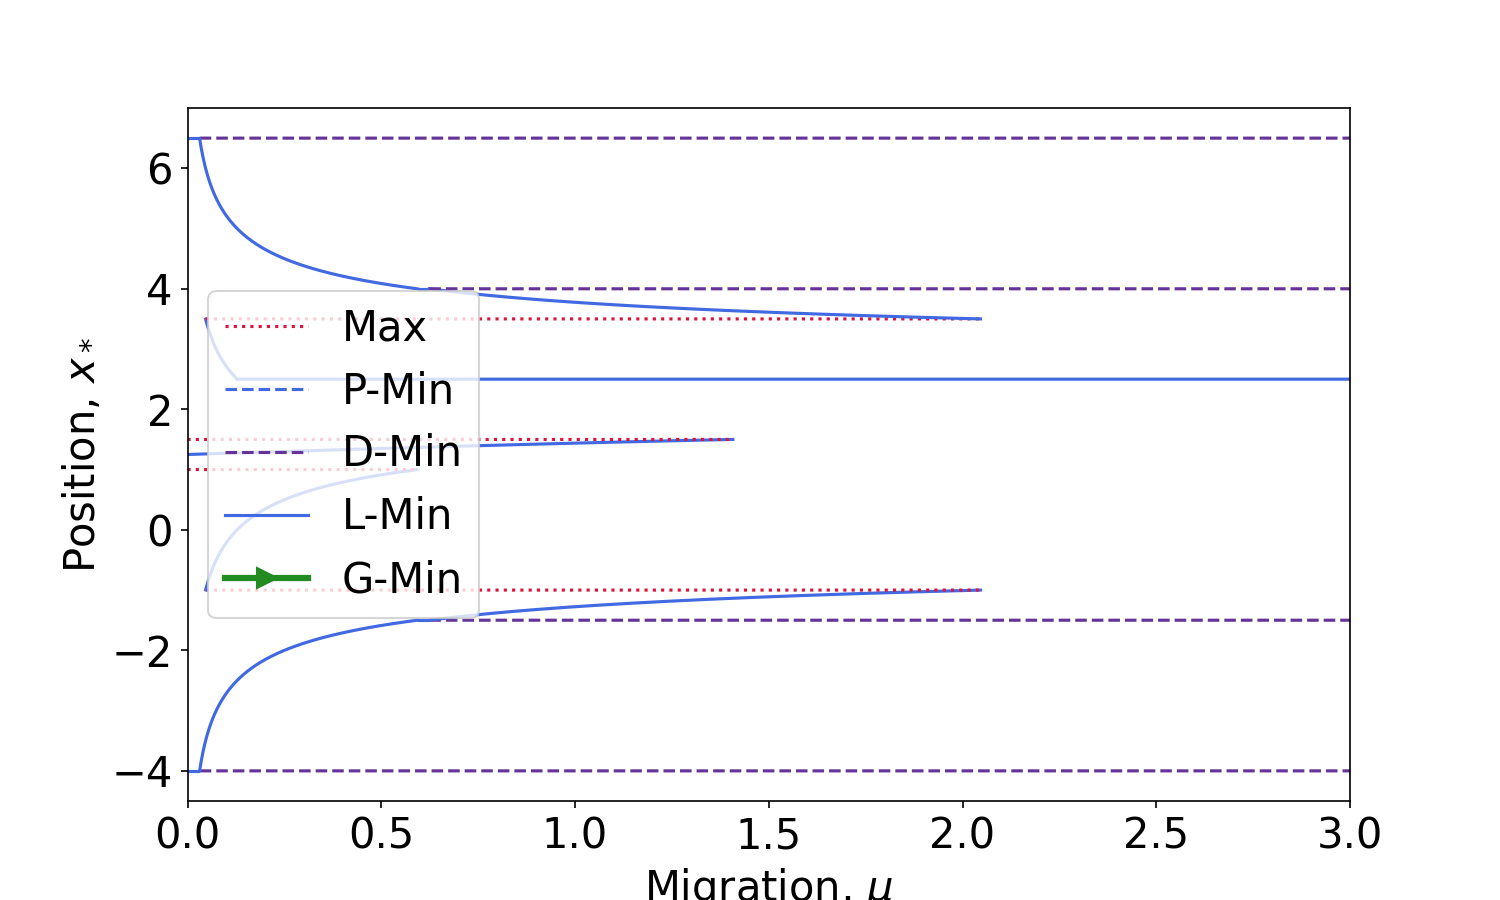

In [48]:
fig=plt.figure(figsize=(10,6))
R=4
mu = np.linspace(0,3,10000)
# mu = np.logspace(-2,1,10000)
plot_stat_points_2dx1(mu,ax=fig.gca(),R=R,x1=2.5,
                      legend_loc='center left')
# ax=fig.gca()
# ax.plot([2,2],[-10,10],'k:',lw=0.5)
# ax.plot([2.25,2.25],[-10,10],'k:',lw=0.5)
# ax.plot([0.25,0.25],[-10,10],'k:',lw=0.5)

# ax.plot([2/(R**3)]*2,[-10,10],'k:',lw=0.5)
# ax.plot([2/((R-1)**3)]*2,[-10,10],'k:',lw=0.5)
# ax.plot([2/((R-1)**3)+2/(R**3)]*2,[-10,10],'k:',lw=0.5)
# ax.set_xscale('log')
# ax.set_xlim([1/R**3,3])
# ax.annotate(r"$2R^{-3}$",[2/(R**3),0],fontsize=15,rotation=-90,va='center')
# fig.savefig('Migratory stationary points 2d log.png',bbox_inches='tight')

# 1D1C - Mobile Defector

<IPython.core.display.Javascript object>


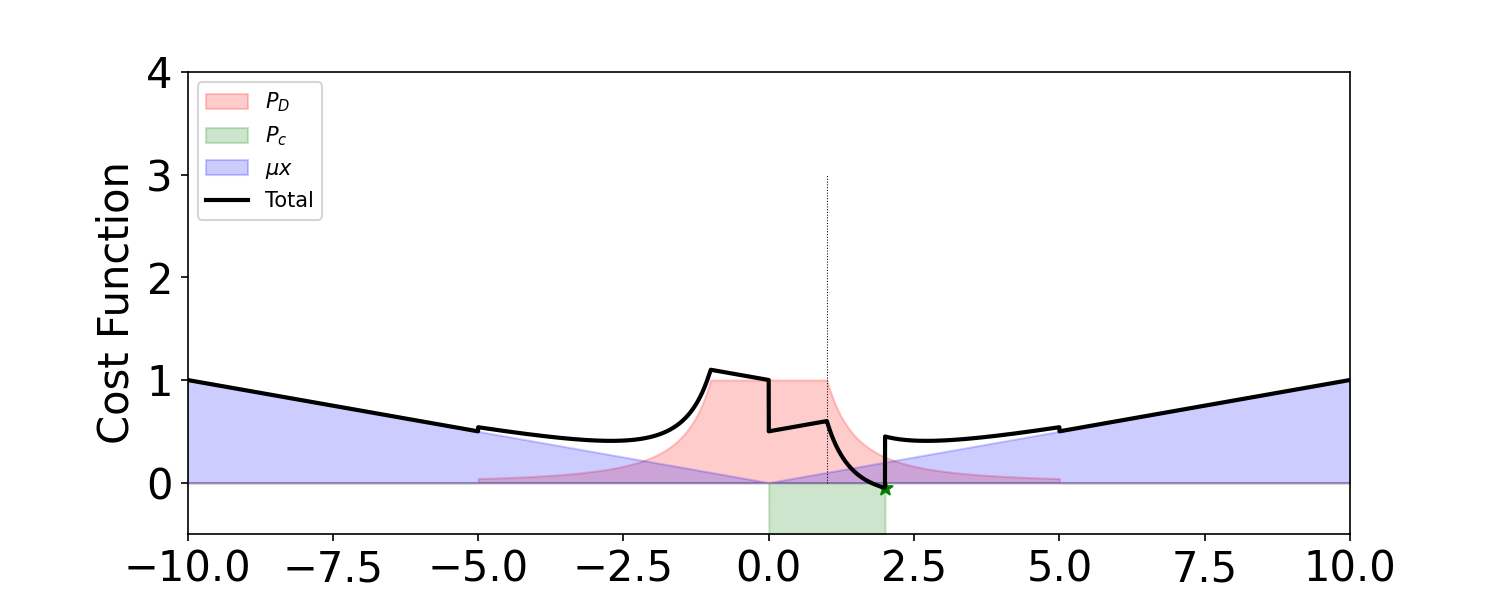

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-0.5, step=0.05), Dropdown(descrip…

In [31]:
fig,ax=plt.subplots(figsize=(10,4))
x0=1
x=np.linspace(-10,10,10000)

@widgets.interact(mu=(-0.5,3,0.05),R=[1,2,5,10],phi=[0.5,1,5])
def update(mu=0,R=5,phi=0.5):
    total=P(x,R=R,x0=0)+clean(x,phi=phi,x0=x0)+m_cost(x,mu=mu,x0=0)
    ax.clear()
    ax.fill_between(x,[0]*len(x),P(x,R=R,x0=0),color='r',label='$P_D$',alpha=0.2,lw=1)
    ax.fill_between(x,clean(x,phi=phi,x0=x0),[0]*len(x),color='g',label='$P_c$',alpha=0.2,lw=1)
    ax.fill_between(x,[0]*len(x),m_cost(x,mu=mu,x0=0),label='$\mu x$',color='b',lw=1,alpha=0.2)
    ax.plot(x,total,label='Total',c='k',lw=2)
    ax.set_xlim([min(x),max(x)])
    ax.set_ylim([-phi,4])
    ax.scatter([x[np.argmin(total)]],
            [np.min(total)],
               marker='*',s=50,c='g')

    ax.legend(loc='upper left',fontsize=10)
    ax.set_xlabel("$x$")
    ax.set_ylabel("Cost Function")
    ax.plot([1,1],[0,3],'k:',lw=0.5)
    plt.show()

# 2C

<IPython.core.display.Javascript object>


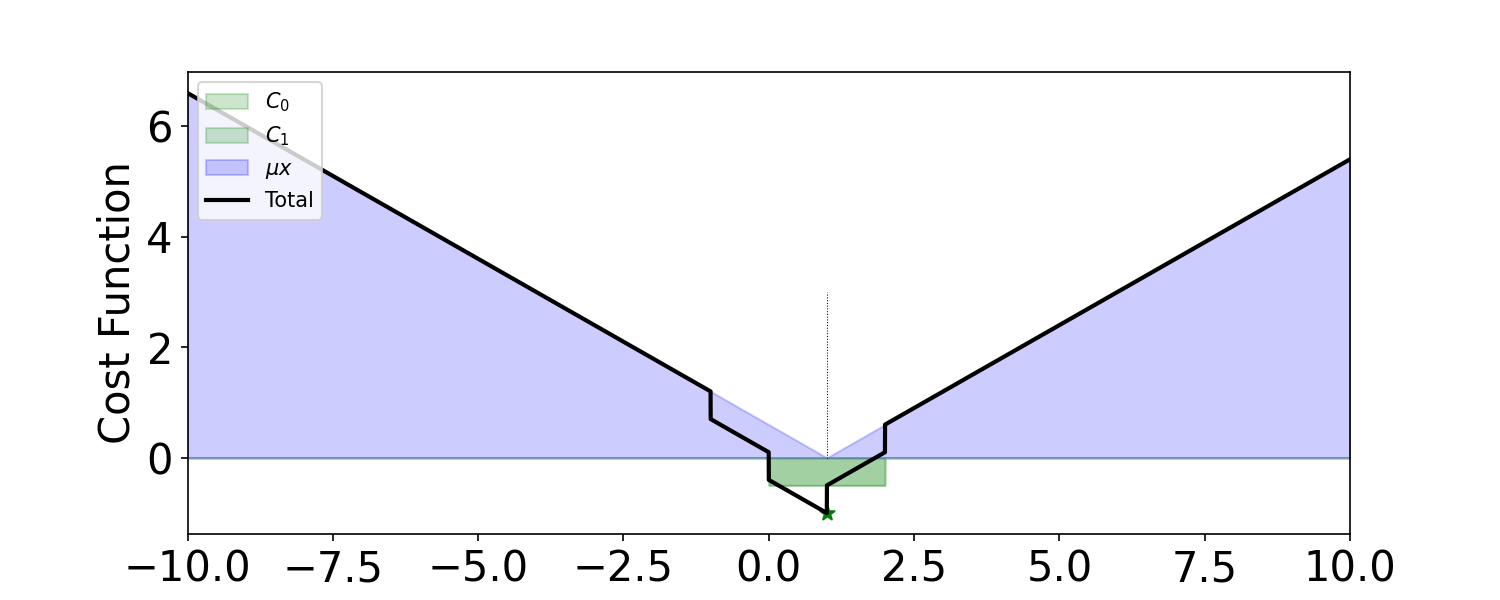

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-0.5, step=0.05), Dropdown(descrip…

In [132]:
fig,ax=plt.subplots(figsize=(10,4))
x0=1
x=np.linspace(-10,10,10000)

@widgets.interact(mu=(-0.5,3,0.05),R=[1,2,5,10],phi=[0.5,1,5])
def update(mu=0,R=5,phi=0.5):
    total=clean(x,phi=phi,x0=0)+clean(x,phi=phi,x0=x0)+m_cost(x,mu=mu,x0=1)
    ax.clear()
    ax.fill_between(x,clean(x,phi=phi,x0=1),[0]*len(x),color='g',label='$C_0$',alpha=0.2,lw=1)
    ax.fill_between(x,clean(x,phi=phi,x0=x0),[0]*len(x),color='g',label='$C_1$',alpha=0.2,lw=1)
    ax.fill_between(x,[0]*len(x),m_cost(x,mu=mu,x0=x0),label='$\mu x$',color='b',lw=1,alpha=0.2)
    ax.plot(x,total,label='Total',c='k',lw=2)
    ax.set_xlim([min(x),max(x)])
#     ax.set_ylim([-phi,4])
    ax.scatter([x[np.argmin(total)]],
            [np.min(total)],
               marker='*',s=50,c='g')

    ax.legend(loc='upper left',fontsize=10)
    ax.set_xlabel("$x$")
    ax.set_ylabel("Cost Function")
    ax.plot([1,1],[0,3],'k:',lw=0.5)
    plt.show()

# Global Mins

In [4]:
def f_dd(x,par):
    mu,x1,R,_ = par
    res = (np.abs(x)<1)*1 + (np.abs(x-x1)<1)*1 + np.abs(x-x1)*mu
    if (np.abs(x)>=1)&(np.abs(x)<R):
        res += 1/x**2
    if (np.abs(x-x1)>=1)&(np.abs(x-x1)<R):
        res += 1/(x-x1)**2
    return res

def f_dc(x,par):
    mu,x1,R,phi = par
    res = (np.abs(x)<1)*1 - (np.abs(x-x1)<=1)*phi + np.abs(x-x1)*mu
    if (np.abs(x)>=1)&(np.abs(x)<R):
        res += 1/x**2
    return res

def f_cd(x,par):
    mu,x1,R,phi = par
    res = (np.abs(x)<=1)*(-1*phi) + (np.abs(x-x1)<1)*1 + np.abs(x-x1)*mu
    if (np.abs(x-x1)>=1)&(np.abs(x-x1)<R):
        res += 1/(x-x1)**2
    return res

def f_cc(x,par):
    mu,x1,R,phi = par
    res = (np.abs(x)<=1)*(-1*phi) - (np.abs(x-x1)<=1)*phi + np.abs(x-x1)*mu
    return res

<IPython.core.display.Javascript object>


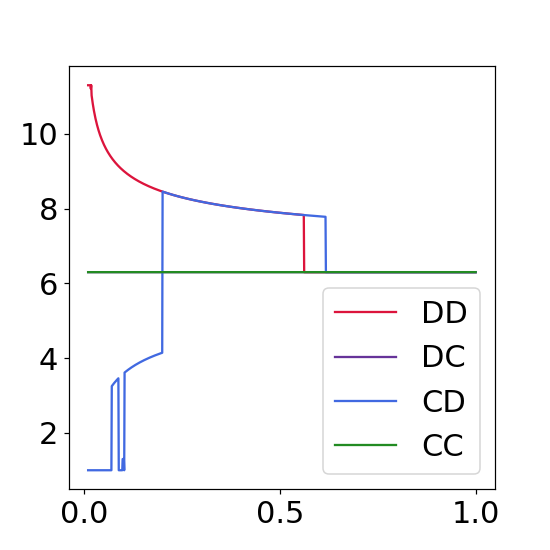

interactive(children=(FloatSlider(value=1.0, description='x1', max=10.0, min=1.0), Dropdown(description='R', i…

In [6]:
mu = np.linspace(0.01,1,1000)
fig,ax=plt.subplots(figsize=(5,5))
@widgets.interact(x1=(1,10,0.1),R=[1,2,5,10],phi=[0.5,1,5])
def update(x1=1,R=5,phi=5):
    ax.clear()
    gmin_dd = np.array([minimize_scalar(f_dd,method='bounded',
                                        bounds=(-R-0.5,R+x1+0.5),
                                        args=[Mu,x1,R,phi]).x for Mu in mu])
    gmin_dc = np.array([minimize_scalar(f_dc,method='bounded',
                                        bounds=(-R-0.5,R+x1+0.5),
                                        args=[Mu,x1,R,phi]).x for Mu in mu])
    gmin_cd = np.array([minimize_scalar(f_cd,method='bounded',
                                        bounds=(-R-0.5,R+x1+0.5),
                                        args=[Mu,x1,R,phi]).x for Mu in mu])
    gmin_cc = np.array([minimize_scalar(f_cc,method='bounded',
                                        bounds=(-R-0.5,R+x1+0.5),
                                        args=[Mu,x1,R,phi]).x for Mu in mu])
    ax.plot(mu,gmin_dd,c='crimson',label='DD')
    ax.plot(mu,gmin_dc,c='rebeccapurple',label='DC')
    ax.plot(mu,gmin_cd,c='royalblue',label='CD')
    ax.plot(mu,gmin_cc,c='forestgreen',label='CC')
    ax.legend()
    plt.show()